# Regression of morphological feature groups for C-independant phenotypes
For each drug, OLS regression is performed for every single morphological feature group (e.g. area, shape, texture) against the drug concentration. The resulting regression coefficients are then used to create a C invariant phenotype for each morphological feature group. The C invariant phenotypes are then used to create a hierarchical clustering of the drugs. New toxicity phenotypes are hence obtained, that we wish to compare with the original phenotypes for applications such as property prediction.

## Data loading
Normalized well-level profiles are loaded from CSV, and basic data processing is performed. The script is automatically adapting to CellProfiler and Harmony data depending by lookup at the "Concentration" column name. If data is not normalized, rMAD can be performed by setting the `normalize` parameter to `True`.

Feature categories are inferred by the "cp_feature_classifier" function from the toxifate python package.

In [1]:
# start 01/08/2023, work in progress
# following the trend of top features (high STD) along the concentration gradient in Cell Painting data

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from toxifate import *

pd.options.mode.chained_assignment = None  # default='warn'

normalize = False

# read in Cell Painting data
path = r"C:\Users\Roman\OneDrive - National University of Ireland, Galway\CellPainting project data\CellProfiler\PerWell\tubesMonoByWellProfiler.csv"
cp_df = pd.read_csv(path).drop(['Unnamed: 0','Count','Row','Column'], axis=1, errors='ignore')
# drop inf and nan values
cp_df = cp_df.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how="any")
file_name = path.split('\\')[-1].split('.')[0]
print(file_name)

if 'Concentration' in cp_df.columns:
    file_type = 'harmony'
    conc_col = 'Concentration'
    plate_col = 'PlateName'
    print('Harmony data')
else:
    file_type = 'cellprofiler'
    conc_col = 'Metadata_Concentration (Image)'
    plate_col = 'PlateID'
    print('Cell Profiler data')

if normalize == True :
    cp_df.reset_index(inplace=True)
    concat_table = pd.DataFrame()
    for plate in cp_df.PlateID.unique():
        temp_df = cp_df.loc[cp_df.PlateID == plate]
        metaFeatureList = ['PlateID','Metadata_Well','Metadata_Concentration (Image)','Compound']
        featureList = list(set(temp_df.columns.to_list()) - set(metaFeatureList))
        normalized = pcm.normalize(temp_df, samples="Compound=='DMSO'", features=featureList,
                                    meta_features=metaFeatureList, method="robustize", mad_robustize_epsilon=0)
        concat_table = pd.concat([concat_table, normalized], axis=0)
    cp_df = concat_table


feature_categories = cp_feature_classifier(cp_df, file_type)
#count the number of features by category
#feature_categories['FeatureCategory'].value_counts()




tubesMonoByWellProfiler
Cell Profiler data


# Main loop for OLS regression and feature group-wise score computation
For each drug in the normalized well profiles and each biological replicate, we compute the standard deviation of all individual features. The top 200 features with higest STD are kept to remove noisy ones or features with no significant trend. OLS regression yields a slope, intercept and R2 value for each feature. Weak slopes (here set at below 0.3 in absolute value) are removed. A score is computed for each feature group to infer the "positiveness" or "negativeness" of the regression, weighted by the number of features in each group. In this current state, a single significant slope can make the whole group significant. This could be improved by using a more robust statistic such as the median of the slopes.

In [2]:
# individual replicates processes separately

weak_threshold = 0.3

full_feature_stats = pd.DataFrame()
full_slope_table = pd.DataFrame()
feature_categories = cp_feature_classifier(cp_df, file_type=file_type)
slope_df_concat = pd.DataFrame()

for drug in cp_df['Compound'].unique():
    cp_df_drug = cp_df.loc[cp_df['Compound'] == drug]
    for replicate in cp_df_drug[plate_col].unique():
        cp_df_drug_rep = cp_df_drug.loc[cp_df_drug[plate_col] == replicate]
    # compute standard deviation of all features, and plot the distribution of standard deviations
        std = cp_df_drug_rep.drop([conc_col], axis=1).std(axis=0, numeric_only=True).sort_values(ascending=False)
        std_50 = std[:200] #std_50 = std[:50]

        cp_df_50 = cp_df_drug_rep[std_50.index]
        cp_df_50[conc_col] = cp_df_drug_rep[conc_col]
        # table wide to long
        cp_df_50 = cp_df_50.melt(id_vars=[conc_col], var_name='feature', value_name='value')
        cp_df_50['logConcentration'] = np.log(cp_df_50[conc_col]+1)

        feature_list = cp_df_50['feature'].unique()
        slope_list = []

        for feature in cp_df_50['feature'].unique():
            y = cp_df_50[cp_df_50['feature'] == feature]['value']
            X = cp_df_50[cp_df_50['feature'] == feature]['logConcentration']
            X = sm.add_constant(X) # for intercept
            model = sm.OLS(y, X)
            results = model.fit()
            slope_list.append(results.params[1])
        slope_df = pd.DataFrame({'feature':feature_list, 'slope':slope_list})

        # join slope_df with feature_categories to get feature_type for each feature
        slope_df = pd.merge(slope_df, feature_categories, left_on='feature', right_on='Feature', how='left')

        # count number of positive slope values per feature_type
        slope_df['positive_slopes'] = np.where(slope_df['slope'] > weak_threshold, 1, 0)
        slope_df['negative_slopes'] = np.where(slope_df['slope'] < -weak_threshold, 1, 0)
        slope_df['weak_slopes'] = np.where(slope_df['slope'].abs() < weak_threshold, 1, 0)
        slope_df.rename(columns={'FeatureCategory':'feature_type'}, inplace=True)
        slope_df['PlateID'] = replicate
        slope_df['drug'] = drug
        slope_df_concat = pd.concat([slope_df_concat, slope_df], axis = 0)

    feature_stats = slope_df_concat.groupby(['feature_type','drug']).agg({'feature': 'count', 'positive_slopes':'sum', 'negative_slopes':'sum', 'weak_slopes':'sum'}).reset_index()
    
    feature_stats.sort_values(by='feature_type')

feature_stats['score'] = ((feature_stats['positive_slopes'] - feature_stats['negative_slopes'])/ (feature_stats['positive_slopes'] + feature_stats['negative_slopes']))
# drop feature_type that contains 'Location'
feature_stats = feature_stats[~feature_stats['feature_type'].str.contains('Location|Parent|Number|Neighbors')]
full_feature_stats = feature_stats
feature_stats

,feature_type,drug,feature,positive_slopes,negative_slopes,weak_slopes,score
0,Cells_AreaShape_Global,ATOR,14,3,7,4,-0.400000
1,Cells_AreaShape_Global,CERI,11,2,6,3,-0.500000
2,Cells_AreaShape_Global,CISP,14,0,1,13,-1.000000
3,Cells_AreaShape_Global,CLEV,6,0,1,5,-1.000000
4,Cells_AreaShape_Global,CLOF,15,0,0,15,NaN
...,...,...,...,...,...,...,...
1541,Nuclei_Texture_RNA,SUNI,28,28,0,0,1.000000
1542,Nuclei_Texture_RNA,TEBU,40,17,18,5,-0.028571
1543,Nuclei_Texture_RNA,VORI,60,20,20,20,0.000000
1544,Nuclei_Texture_RNA,WURS,65,28,25,12,0.056604


In [3]:
#full_feature_stats.groupby(['feature_type']).agg({'feature':['']}).sort_values(('feature','sum'), ascending=False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.8330
Date:                Fri, 13 Oct 2023   Prob (F-statistic):              0.369
Time:                        16:16:58   Log-Likelihood:                -44.637
No. Observations:                  32   AIC:                             93.27
Df Residuals:                      30   BIC:                             96.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0635      0.467      0.136      0.893      -0.891       1.018
logConcentration    -0.0624      0.068     -0.913      0.369      -0.202       0.077
==============================================================================
Omnibus:                        0.758   Durbin-Watson:                   2.833
Prob(Omnibus):                  0.685   Jarque-Bera (JB):                0.634
Skew:                           0.324   Prob(JB):                        0.728
Kurtosis:                       2.765   Cond. No.                         18.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Line plot of a single feature across 3 replicates
Visualizing the different replicates for a single feature, and its standard deviation for each concentration.

[None]

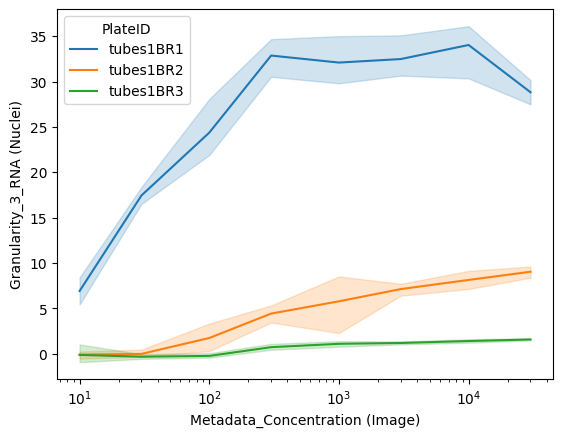

In [4]:
# line plot of Texture_DifferenceEntropy_RNA_3_02_256 (Cytoplasm) in ZIDO
scatter_zido = sns.lineplot(x=conc_col, y=cp_df.columns[50], hue=plate_col, data=cp_df.loc[cp_df['Compound'] == 'CERI'])
scatter_zido.set(xscale="log")

## Clustering of drug profiles based on feature group regression
Pivoting table and filling missing values with 0
Hierarchical clustering done with complete linkage and cityblock distance

Clustermap for tubesMonoByWellProfiler


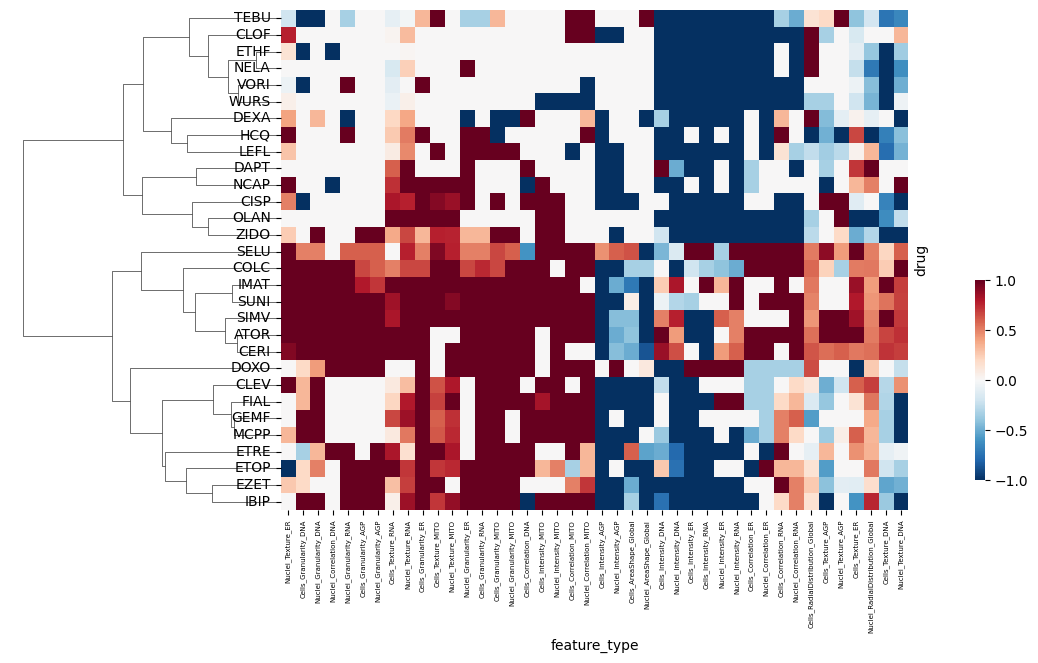

In [9]:
# create clustermap of the pivot table
import seaborn as sns
import matplotlib.pyplot as plt


#pivot table and use score as value, drug as column, feature_type as index
pivot = full_feature_stats.pivot_table(index='drug', columns='feature_type', values='score').fillna(0)
pivot.drop(['Parent', 'Location','Number','Neighbors'], axis=1, inplace=True, errors='ignore')
#create mask for clustermap to display only NCAP ATOR CERI CLOF COLC DAPT
mask = np.ones_like(pivot)

mask[0:2,:] = False
mask[4:7,:] = False
mask[20,:] = False
mask[24,:] = False



g = sns.clustermap(pivot, center=0, cmap='RdBu_r',row_cluster=True, col_cluster=True, method='complete', xticklabels=True, metric='cityblock',dendrogram_ratio=0.3)
x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([0.98, 0.3, 0.01, 0.2])
g.ax_cbar.tick_params(axis="x", length=10)
#reduce font size to fit xlabels
g.tick_params(axis="x", which="both", labelsize=5)
g.ax_heatmap.yaxis.tick_left()
print("Clustermap for "+file_name)
g.ax_col_dendrogram.set_visible(False)
g.ax_heatmap.get_agg_filter()
#g.ax_row_dendrogram.set_position([0.015, 0.322, 0.194, 0.652])



In [10]:
"""# plot the evolution of the features with the highest standard deviations, against the concentration of treatments. take the top 10 features in std Serie
# "Metadata_Concentration (Image)" and "Count" are metadata columns
std.sort_values(ascending=False, inplace=True)
std_top = std[:20]
cp_df_filtered = cp_df[std_top.index]
cp_df_filtered[conc_col] = cp_df[conc_col]
# table wide to long
cp_df_filtered = cp_df_filtered.melt(id_vars=[conc_col], var_name='feature', value_name='value')
cp_df_filtered['feature_type'] = cp_df_filtered['feature'].str.split('_').str[0]
sns.set_context("paper")

if file_type == 'cellprofiler':
    feature_type_palette = {"Granularity": "C0", "Intensity": "C1", "RadialDistribution": "C2", "AreaShape": "C3", "Texture": "C4", "Correlation":"C5", 'Neighbors':"C6", "Location":"C7", "Parent":"C8", "Number":"C9"}
elif file_type == 'harmony':
    feature_type_palette = {'Cell Mito Axial Small Length SER-Edge':"C0", 'Cell 33342 Radial Mean Ratio SER-Bright':"C0", 'Cell 488 Axial Small Length SER-Edge':"C0", 'Cytoplasm 33342 Profile 3/5' :"C0", 'Nucleus 33342 Axial Small Length SER-Edge':"C0", 'Nucleus 33342 Threshold Compactness 30% SER-Bright':"C0", 'Cell Mito Axial Small Length SER-Dark':"C0", 'Nucleus 33342 Threshold Compactness 50% ':"C0", 'Cell Mito Axial Small Length SER-Hole':"C0", 'Nucleus 33342 Threshold Compactness 40% SER-Bright':"C0", 'Cell Mito Axial Small Length SER-Valley':"C0", 'Nucleus HOECHST 33342 SER Saddle 0 px':"C0", 'Cell 33342 Radial Mean Ratio SER-Ridge':"C0", 'Cell 488 Axial Small Length SER-Saddle':"C0", 'Cell 33342 Radial Mean Ratio SER-Spot':"C0", 'Nucleus 33342 Threshold Compactness 60% SER-Hole':"C0", 'Cell 568 Threshold Compactness 30% ':"C0", 'Cell 568 Axial Small Length SER-Saddle':"C0", 'Cell Mito Axial Small Length SER-Ridge':"C0", 'Nucleus 33342 Radial Mean Ratio SER-Valley':"C0"}

g = sns.relplot(
    data=cp_df_filtered,
    x=conc_col, y="value", kind="line", col='feature', hue='feature_type',col_wrap=5, markers=True, palette=feature_type_palette)
g.set(xscale="log")"""


'# plot the evolution of the features with the highest standard deviations, against the concentration of treatments. take the top 10 features in std Serie\n# "Metadata_Concentration (Image)" and "Count" are metadata columns\nstd.sort_values(ascending=False, inplace=True)\nstd_top = std[:20]\ncp_df_filtered = cp_df[std_top.index]\ncp_df_filtered[conc_col] = cp_df[conc_col]\n# table wide to long\ncp_df_filtered = cp_df_filtered.melt(id_vars=[conc_col], var_name=\'feature\', value_name=\'value\')\ncp_df_filtered[\'feature_type\'] = cp_df_filtered[\'feature\'].str.split(\'_\').str[0]\nsns.set_context("paper")\n\nif file_type == \'cellprofiler\':\n    feature_type_palette = {"Granularity": "C0", "Intensity": "C1", "RadialDistribution": "C2", "AreaShape": "C3", "Texture": "C4", "Correlation":"C5", \'Neighbors\':"C6", "Location":"C7", "Parent":"C8", "Number":"C9"}\nelif file_type == \'harmony\':\n    feature_type_palette = {\'Cell Mito Axial Small Length SER-Edge\':"C0", \'Cell 33342 Radial M

In [11]:
"""# loc cp_df where 'Compound' == 'CLEV'

cp_clev = cp_df.loc[cp_df['Compound'] == 'ATOR']
cp_clev
# scatter plot of Granularity_1_MITO (Cells) against Metadata_Concentration (Image)

scatter = sns.lineplot(data=cp_clev, x='Metadata_Concentration (Image)', y=cp_clev.columns[95], hue='PlateID', palette='bright')
scatter.set(xscale="log")"""

'# loc cp_df where \'Compound\' == \'CLEV\'\n\ncp_clev = cp_df.loc[cp_df[\'Compound\'] == \'ATOR\']\ncp_clev\n# scatter plot of Granularity_1_MITO (Cells) against Metadata_Concentration (Image)\n\nscatter = sns.lineplot(data=cp_clev, x=\'Metadata_Concentration (Image)\', y=cp_clev.columns[95], hue=\'PlateID\', palette=\'bright\')\nscatter.set(xscale="log")'

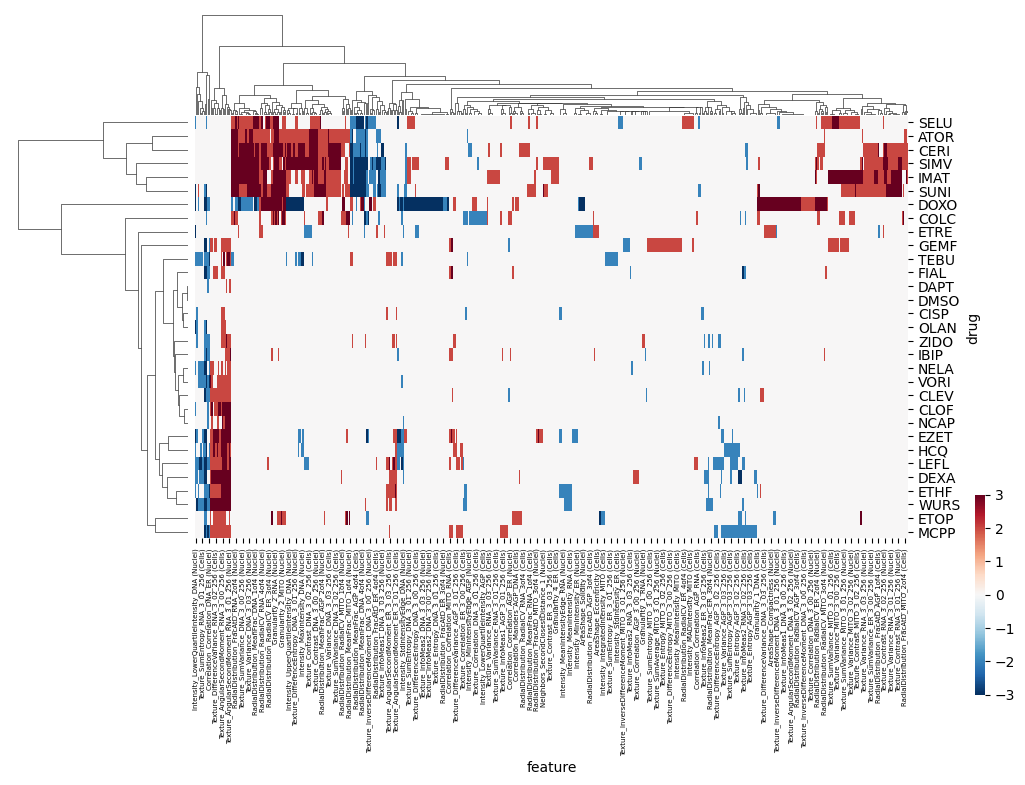

In [12]:
full_slope_table = slope_df_concat.copy()
full_slope_table['slope_score'] = full_slope_table['positive_slopes'] - full_slope_table['negative_slopes']
full_slope_table_agg = full_slope_table.groupby(['drug', 'feature']).agg({'slope_score': 'sum'}).reset_index()
# set -1 and 1 to 0
full_slope_table_agg = full_slope_table_agg.replace(-1, 0)
full_slope_table_agg = full_slope_table_agg.replace(1, 0)
#full_slope_table_agg = full_slope_table_agg.replace(-3, -1)
#full_slope_table_agg = full_slope_table_agg.replace(3, 1)
#full_slope_table_agg = full_slope_table_agg.replace(-2, -1)
#full_slope_table_agg = full_slope_table_agg.replace(2, 1)




full_slope_table_piv = full_slope_table_agg.pivot_table(index='drug', columns='feature', values='slope_score').fillna(0)
#drop features containing more than 95% of 0
#full_slope_table_piv = full_slope_table_piv.loc[:, (full_slope_table_piv == 0).mean() < .95]
#drop features with 0 standard deviation
full_slope_table_piv = full_slope_table_piv.loc[:, full_slope_table_piv.std() > 0]


#keep only NCAP ATOR CERI CLOF COLC DAPT
#full_slope_table_piv = full_slope_table_piv.loc[['DEXA', 'DOXO', 'SIMV', 'COLC', 'ETOP', 'ATOR'], :]
h = sns.clustermap(full_slope_table_piv, center=0, cmap='RdBu_r',row_cluster=True, col_cluster=True, method='complete', xticklabels=5, metric='cityblock')
x0, _y0, _w, _h = h.cbar_pos
h.ax_cbar.set_position([0.98, 0.3, 0.01, 0.2])
h.ax_cbar.tick_params(axis="x", length=10)
#reduce font size to fit xlabels
h.tick_params(axis="x", which="both", labelsize=5)
corr_table = full_slope_table_piv.corr()